# Update parameters

## SGD

SGD is the simple way to find the optimal parameters by using the gradient of the parameters.
The following equation means a simple equation that goes only a certain distance in the inclined direction.
$$W{\leftarrow}W-\eta \frac{\partial L}{\partial W}$$ ($W$ = weights, $\eta$ = learning rate, $\frac{\partial L}{\partial W}$ = gradient of loss function to $W$)

In [20]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### shortcoming of SGD

In SGD, the search path is inefficient in anisotropic function(비등방성 함수) (a function in which the point indicated by the gradient at a specific coordinate(좌표) may change). Momentum, AdaGrad, and Adam are three ways to improve this shortcoming.

## Momentum

Momentum uses the rate of change of the parameter updated by the combination of the current gradient and the momentum accumulated in the previous stage. 
Simply put, the momentum adjusts the parameter in a better direction in the current stage, supported by the direction of parameter update in the previous stage. 
For example, a ball appears to roll on the bottom of the bowl.
$$v{\leftarrow}av-\eta \frac{\partial L}{\partial W}$$
$$W{\leftarrow}W+v$$

In [21]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

## AdaGrad

In the learning process of a neural network, the learning rate value is crucial. When its value is too small, the learning process takes too long, and when it is too large, the learning quality deteriorates.

The way to solve this problem is to learn large at first and then learn little by little. AdaGrad realized this method, and learning proceeds while adaptively adjusting the learning rate to individual parameters.

$$h\leftarrow h + \frac{\partial L}{\partial W}\odot\frac{\partial L}{\partial W}$$
$$W\leftarrow W - \eta\frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$$
($\odot$ = element-wise multiplication of matrices)

In [22]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
        for key, val in params.items():
            self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## Adam

Adam is a combination of Momentum and AdaGrad benefits.
There is not always an outstanding method for every problem, so it is different to use the appropriate method depending on the problem.

# Initial value of weights

There is a weight decay technique to suppress overfitting. 
This is a method of learning so that the value of the weight parameter becomes small.
To find a very small value of weight, observing the distribution of activation values in the hidden layer provides important insights. 
The following experiment investigates how the activation values in the hidden layer change depending on the initial values of the weights.

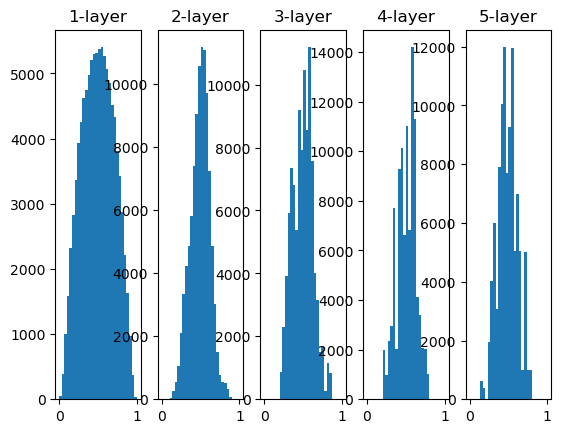

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #initial value of Xavier
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

# Batch Normalization

Batch Normalization's idea is adjusting the activation values to be appropriately distributed across each layer. 
There are some reasons why Batch Normalization is widely used.

1. to proceed learning fastly
2. not depend on initial value
3. suppress overfitting

This is the formula about Batch Normalization that making the data distribution have a mean of 0 and a variance(분산) of 1.

$$\mu _{b} \leftarrow \frac{1}{m}\sum_{m}^{i=1}x_{i}$$
$$\sigma _{B}^{2} \leftarrow \frac{1}{m}\sum_{m}^{i=1}(x_{i} - \mu _{b})^{2}$$
$$\hat{x}_{i} \leftarrow \frac{x_{i} - \mu _{b}}{\sqrt{\sigma _{B}^{2} + \varepsilon }}$$

# Consideration for learning

## Overfitting

Overfitting occurs when the train data is lack or the model has a lot of parameters and high expressiveness.
To prevent overfitting, weight decay and dropout can be used.

## Weight decay

Weight decay is the method that give penalty to the large weights correspondingly.

## Dropout

When the neural network becomes sophisticated, it is difficult to handle overfitting with only weight decay.
So, Dropout that deletes the neurons randomly can be used.

In [24]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask